In [1]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from scipy.ndimage import gaussian_filter
from mne.stats import spatio_temporal_cluster_test, f_mway_rm, f_threshold_mway_rm

In [2]:
plt.rcParams.update({
        'font.size': 16,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'xtick.major.size': 6,
        'xtick.major.width': 1.2,
        'ytick.major.size': 6,
        'ytick.major.width': 1.2,
        'legend.frameon': False,
        'legend.handletextpad': 0.1,
        'svg.fonttype': 'none',
        'text.usetex': False
    })

In [3]:
path = '/home/common/bonaiuto/stop_go_bursts/derivatives/Dataset_1/'

# combine bursts_all_results and bursts_all_results_cue
bursts_all_results_laplac = np.load(f'{path}/bursts_all_results_laplac.npy', allow_pickle=True)

In [4]:
all_bursts={
    'trial': [],
    'waveform': [],
    'peak_freq': [],
    'peak_amp_iter': [],
    'peak_amp_base': [],
    'peak_time': [],
    'peak_adjustment': [],
    'fwhm_freq': [],
    'fwhm_time': [],
    'polarity': [],
    'waveform_times': [],
    'condition': [],
    'electrode': [],
    'subject': [],
    'experiment': [],
    'epochs': []
}
for bursts in bursts_all_results_laplac:
    for key in bursts:
        if not key=='waveform_times':
            all_bursts[key].extend(bursts[key])
        else:
            all_bursts[key]=bursts[key]
            
for key in all_bursts:
    all_bursts[key]=np.array(all_bursts[key])

In [5]:
c3_idx=(all_bursts['electrode']=='C3')
f4_idx=(all_bursts['electrode']=='F4')


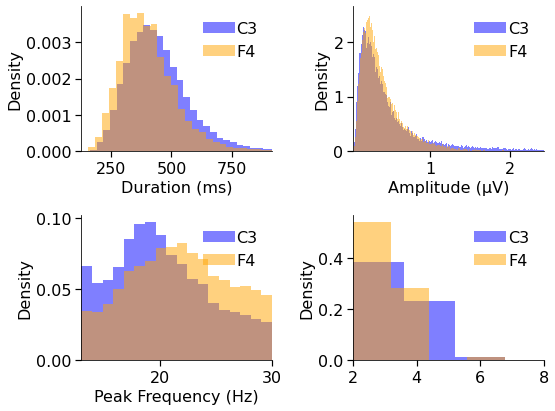

In [16]:

# Prepare the figure with GridSpec layout
fig = plt.figure(figsize=(8, 6))

# Duration distribution (top right of second row)
ax = plt.subplot(2,2,1)
ax.hist(all_bursts['fwhm_time'][c3_idx]*1e3, bins=100, alpha=0.5, color="blue", label="C3", density=True)
ax.hist(all_bursts['fwhm_time'][f4_idx]*1e3, bins=100, alpha=0.5, color="orange", label="F4", density=True)
ax.set_xlabel("Duration (ms)")
ax.set_xlim(np.percentile(all_bursts['fwhm_time']*1e3,[0,99]))
ax.set_ylabel("Density")
ax.legend()

# Amplitude distribution (top left of second row)
ax = plt.subplot(2,2,2)
ax.hist(all_bursts['peak_amp_base'][c3_idx]*1e3, bins=1000, alpha=0.5, color="blue", label="C3", density=True)
ax.hist(all_bursts['peak_amp_base'][f4_idx]*1e3, bins=1000, alpha=0.5, color="orange", label="F4", density=True)
ax.set_xlabel("Amplitude (µV)")
ax.set_xlim(np.percentile(all_bursts['peak_amp_base']*1e3,[0,99]))
ax.set_ylabel("Density")
ax.legend()

# Peak frequency distribution (bottom left)
ax = plt.subplot(2,2,3)
ax.hist(all_bursts['peak_freq'][c3_idx], bins=18, alpha=0.5, color="blue", label="C3",density=True)
ax.hist(all_bursts['peak_freq'][f4_idx], bins=18, alpha=0.5, color="orange", label="F4",density=True)
ax.set_xlabel("Peak Frequency (Hz)")
ax.set_xlim(np.percentile(all_bursts['peak_freq'],[0,100]))
ax.set_ylabel("Density")
ax.legend()

# Frequency span distribution (bottom right)
ax = plt.subplot(2,2,4)
ax.hist(all_bursts['fwhm_freq'][c3_idx], bins=10, alpha=0.5, color="blue", label="C3",density=True)
ax.hist(all_bursts['fwhm_freq'][f4_idx], bins=10, alpha=0.5, color="orange", label="F4",density=True)
ax.set_xlim(np.percentile(all_bursts['fwhm_freq'],[0,99.95]))
ax.set_ylabel("Density")
ax.legend()

plt.tight_layout()
# plt.show()


In [7]:


def stat_fun(*args):
    return f_mway_rm(
        np.swapaxes(args, 0, 0),
        factor_levels=[3],
        effects='A',
        return_pvals=False,
    )[0]

def plot_overall_burst_rate(b_idx):
    time_bin_size = 0.02
    time_bins = np.arange(-1, 2 + time_bin_size, time_bin_size)

    rates_smoothed = {'FS': [], 'SS': [], 'GO': []}

    subjects=np.unique(all_bursts['subject'])
    # Calculate smoothed burst rates by quantile x condition x subject
    for subject in subjects:
        subj_idx = b_idx & (all_bursts['subject'] == subject)
        for cond in ['FS', 'SS', 'GO']:
            cond_trials = np.unique(
                all_bursts['trial'][subj_idx & (all_bursts['condition'] == cond)]
            )
            unsmoothed_rate, _ = np.histogram(
                all_bursts['peak_time'][subj_idx & (all_bursts['condition'] == cond)],
                bins=time_bins
            )
            # Convert to rate
            unsmoothed_rate = (unsmoothed_rate / time_bin_size) / len(cond_trials)

            smoothed_rate = gaussian_filter(unsmoothed_rate, sigma=2)
            base_idx = np.where((time_bins >= -0.6) & (time_bins < 0))[0]
            base_rate = np.mean(smoothed_rate[base_idx])
            smoothed_rate = smoothed_rate - base_rate

            rates_smoothed[cond].append(smoothed_rate)

    # Truncate last bin
    time_bins = time_bins[:-1]
    idx = np.where((time_bins >= -0.6) & (time_bins <= 1.6))[0]
    time_bins = time_bins[idx]

    # Convert each quantile+condition?s list of arrays to np arrays
    for cond in ['FS', 'SS', 'GO']:
        rates_smoothed[cond] = np.vstack(rates_smoothed[cond])[:, idx]

    plt.figure()
    plt.rcParams.update({
        'font.size': 16,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'xtick.major.size': 6,
        'xtick.major.width': 1.2,
        'ytick.major.size': 6,
        'ytick.major.width': 1.2,
        'legend.frameon': False,
        'legend.handletextpad': 0.1,
        'svg.fonttype': 'none',
        'text.usetex': False
    })

    ax = plt.subplot(1,1,1)

    # Plot grand averages for each condition
    for cond in ['FS', 'SS', 'GO']:
        mean_rate = np.mean(rates_smoothed[cond], axis=0)
        sem_rate = np.std(rates_smoothed[cond], axis=0) / np.sqrt(rates_smoothed[cond].shape[0])
        ax.plot(time_bins, mean_rate, label=cond)
        ax.fill_between(time_bins, mean_rate - sem_rate, mean_rate + sem_rate, alpha=0.2)

    # X shape: (n_subjects, n_conditions, n_times)
    X = np.stack((
        rates_smoothed['FS'],
        rates_smoothed['SS'],
        rates_smoothed['GO']
    ), axis=1)
    print(X.shape)

    # For a one-way repeated-measures ANOVA with 3 levels, define factor_levels=[3].
    # We will test effect 'A' (the only factor).
    factor_levels = [3]
    effects = 'A'  # Single factor

    # Compute threshold for cluster test
    threshold = f_threshold_mway_rm(
        n_subjects=X.shape[0],
        factor_levels=factor_levels,
        effects=effects
    )

    # Run cluster-based permutation on F-stat
    f_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_test(
        X,
        threshold=threshold,
        stat_fun=stat_fun,
        n_permutations=10000,
        tail=1.0,
        n_jobs=-1
    )

    # Mark significant cluster spans
    for (c_inds,), p_val in zip(clusters, cluster_p_values):
        if p_val < 0.05:  # cluster-level alpha
            # c_inds is a slice or range of time indices
            ax.axvspan(
                time_bins[c_inds[0]], 
                time_bins[c_inds[-1]],
                color='yellow', alpha=0.2
            )

    ax.set_xlabel("Task time (s)")
    ax.set_ylabel("Burst rate (baseline-corrected)")
    plt.legend()

    plt.tight_layout()
    plt.show()


(12, 3, 110)
stat_fun(H1): min=0.040390 max=12.759421
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

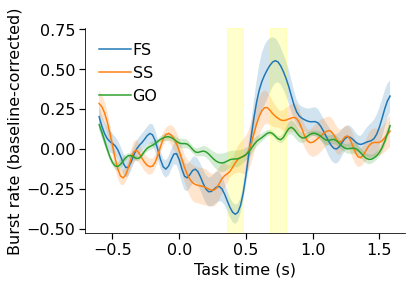

In [8]:
plot_overall_burst_rate(c3_idx)

(12, 3, 110)
stat_fun(H1): min=0.000975 max=6.460130
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

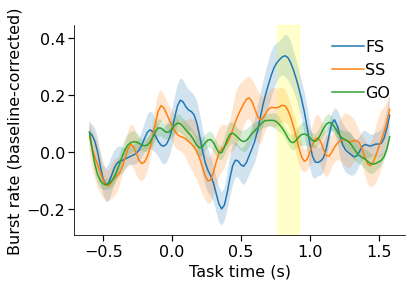

In [9]:
plot_overall_burst_rate(f4_idx)